In [1]:
from __future__ import print_function, division

import shutil
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn

import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
import glob
import random
from PIL import Image
from tqdm import tqdm
import argparse
from bisect import bisect_right, bisect_left

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline

plt.ion()   # interactive mode


# Import data

In [3]:
#Import csv data from folders

imu_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/imu0/data.csv')
camera_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/data.csv')
vicon_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/vicon0/data.csv')

# Drop the first row of the camera

camera_data=camera_data.drop(camera_data.index[[0]])

# re-assign name to columns

vicon_data.columns = ['timestamp','px','py','pz','qw','qx','qy','qz']
camera_data.columns = ['timestamp','filename']
imu_data.columns =['timestamp','wx','wy','wz','ax','ay','az']

# Get the timestamp of the camera and drop the index
camera_timestamps = camera_data['timestamp']
camera_timestamps = camera_timestamps.reset_index(drop=True)


### Interpolate Vicon data to get data at the same timestamp of the camera and IMU
# Vicon data

vicondata = vicon_data.copy() #create a copy

for i in range(len(camera_timestamps)):
    new_row=pd.DataFrame([[camera_timestamps[i],np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]], columns = ['timestamp','px','py','pz','qw','qx','qy','qz'])
    vicondata = pd.concat([vicondata, pd.DataFrame(new_row)], ignore_index=True)
    
vicondata.sort_values(by=['timestamp'],inplace=True, ascending=True)
vicondata = vicondata.reset_index(drop = True)
vicondata = vicondata.interpolate()

   

## Create new sincronized dataframe

In [4]:

def return_idx(timestamps, data):
    "Return the idx of the timestamp of the camera"
    
    idx_sensor = []
    for temp in timestamps:
        idx=int(data[data['timestamp']==temp].index[0])
        idx_sensor.append(idx)
    return idx_sensor

In [5]:
# Create a new vicon dataframe with the same timestamps of the camera

idx_vicon=return_idx(camera_timestamps,vicondata)
new_vicon = vicondata.ix[idx_vicon].reset_index(drop=True)

vicon_timestamp = new_vicon['timestamp'].values

# Create a new IMU dataframe with the same timestamps of the camera

idx_imu = return_idx(camera_timestamps, imu_data)
new_imu = imu_data.ix[idx_imu].reset_index(drop=True)
imu_timestamp = new_imu['timestamp'].values

# Create new dataframe for images and save it

image_data = pd.merge(camera_data,new_vicon, on='timestamp').reset_index(drop=True)
image_data.to_csv(r'/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv',index = None, header=True)

# Import Images and split into training, validation and testing 

### Some testing

In [6]:
# Let’s read the CSV and get the filenames and labels

file = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv')

img_name = file.iloc[:, 1]
labels = file.iloc[:, 2:].as_matrix()

## Create Customized Dataset 

In [7]:
class ImuDataset(Dataset):
    def __init__(self, csv_file, imu_path):
        """
        Args:
            csv_path (string): path to csv file
            imu_data (string): path to the IMU file 
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv(csv_file)
        # First column contains the image paths
        self.imu_data = pd.read_csv(imu_path)

        # Second - 7th columns contains the angular rate and acceleration
        self.imu_arr = self.imu_data.iloc[:, 1:].as_matrix()
        self.imu_arr = self.imu_arr.astype('float')


        # Third - 8th columns contains the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 2:])
        # Calculate len
        self.data_len = len(self.data_info.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        # Get imu data from the pandas 
        imu_data = self.imu_arr

        # Transform image to tensor
#         imu_as_tensor = self.to_tensor(imu_data)

        # Get label(class) of the image based on the cropped pandas column
        label = self.label_arr[index]

        return imu_data, label




In [8]:
class NewDataset(Dataset):
    """Pose dataset."""
    def __init__(self, csv_file, imu_data, root_dir):       
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frame = pd.read_csv(csv_file)
#         self.imu_data = pd.read_csv(imu_path)
        self.imu_data = imu_data
        # Second - 7th columns contains the angular rate and acceleration
        self.imu_arr = self.imu_data.iloc[:, 1:].as_matrix()
        self.imu_arr = self.imu_arr.astype('float')
        
        # Second column contains the image name
        self.image_arr = np.asarray(self.frame.iloc[:, 1])
        
        self.label_arr = np.asarray(self.frame.iloc[:, 2:])
        self.root_dir = root_dir
        # Transforms
        transformation = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])
        self.transform = transformation
        # Calculate len
        self.data_len = len(self.frame.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        single_image_name = self.image_arr[idx]
        fp = self.root_dir
        # Open image
        image = Image.open(fp + single_image_name).convert('RGB')
        image = self.transform(image)
        imu_data = self.imu_arr
        # Get label of the image based on the cropped pandas column
        labels = self.label_arr[idx]

        return image, imu_data, labels

In [9]:
class MyDataset(Dataset):
    """Pose dataset."""
    def __init__(self, csv_file, root_dir):       
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frame = pd.read_csv(csv_file)
        # Second column contains the image name
        self.image_arr = np.asarray(self.frame.iloc[:, 1])
        self.label_arr = np.asarray(self.frame.iloc[:, 2:])
        self.root_dir = root_dir

        transformation = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.4543, 0.4543, 0.4543],[0.3035, 0.3035, 0.3035])
        ])
        self.transform = transformation
        # Calculate len
        self.data_len = len(self.frame.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        single_image_name = self.image_arr[idx]
        fp = self.root_dir
        # Open image
        image = Image.open(fp + single_image_name).convert('RGB')
        image = self.transform(image)

        labels = self.label_arr[idx]

        return image, labels

In [11]:
image_dataset = MyDataset(csv_file='/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv',
                                    root_dir='/home/francesca/Desktop/francesca/data/mav0/cam0/data/')
# newdataset = NewDataset(csv_file='/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv', 
#                          imu_path='/home/francesca/Desktop/francesca/data/mav0/imu0/data.csv',
#                            root_dir='/home/francesca/Desktop/francesca/data/mav0/cam0/data/')

newdataset = NewDataset(csv_file='/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv', 
                         imu_data=new_imu,
                           root_dir='/home/francesca/Desktop/francesca/data/mav0/cam0/data/')
#load the data

dataloader = DataLoader(image_dataset, batch_size=64,
                        shuffle=False, num_workers=0)

#load the data

newdataloader = DataLoader(newdataset, batch_size=64,
                        shuffle=False, num_workers=0)

#### Split into Training and Validation 

In [13]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)



# Functions

In [14]:
def quaternion_angular_error(q1, q2):
    """
    angular error between two quaternions
    :param q1: (4, )
    :param q2: (4, )
    :return:
    """
    d = abs(np.dot(q1, q2))
    abs_q1 = np.linalg.norm(q1)
    abs_q2 = np.linalg.norm(q2)
    d = d / (abs_q1 * abs_q2)
    d = min(1.0, max(-1.0, d))
    theta = 2 * np.arccos(d) * 180 / np.pi
    return theta

# Feature Extractore Network +  Regressor for Camera translation and rotation

In [15]:
class IMUNet(torch.nn.Module):
    
    """Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
               x = F.relu(self.conv1(x))
               return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.
    """

    def __init__(self, feature_extractor, num_features=128, dropout=0.5,
                 track_running_stats=False, pretrained=False):
        super(IMUNet, self).__init__()
        self.dropout = dropout
        self.feature_extractor = feature_extractor
        self.feature_extractor.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        fc_in_features = self.feature_extractor.fc.in_features
        
        self.fc1 = torch.nn.Linear(6,100)
        self.fc2 = torch.nn.Linear( 192100,100)
#         self.fc1 = torch.nn.Linear(1495680,1000)
#         self.fc2 = torch.nn.Linear( 1000,100)
    

        self.fc3 = torch.nn.Linear( num_features + 100, num_features)
        self.feature_extractor.fc = torch.nn.Linear(fc_in_features, num_features)
        # Translation
        self.fc_xyz = torch.nn.Linear(num_features, 3)

        # Rotation in quaternions
        self.fc_quat = torch.nn.Linear(num_features, 4)
        
    def extract_features(self, image):
        x_features = self.feature_extractor(image)
        x_features = F.relu(x_features)
        if self.dropout > 0:
            x_features = F.dropout(x_features, p=self.dropout, training=self.training)
        return x_features
    
    def forward(self, image, imu_data):
        
        #Images
        if type(image) is list:
            x_features = [self.extract_features(xi) for xi in image]
        elif torch.is_tensor(image):
            x_features = self.extract_features(image)
            
            
#         imu_features = imu_data.view(-1, 1495680)
        imu_features = F.relu(self.fc1(imu_data))
        imu_features = imu_features.view(imu_features.size()[0], -1)
        imu_features = F.relu(self.fc2(imu_features))


#         print(imu_features.shape)
#         print(x_features.shape)
        x = torch.cat((x_features, imu_features), dim=1)
        x = F.relu(self.fc3(x))


#         print(x)
#         x = torch.cat((z, y), 1)
        if type(x) is list:
#             x_features = [self.extract_features(xi) for xi in x]
            x_translations = [self.fc_xyz(xi) for xi in x]
            x_rotations = [self.fc_quat(xi) for xi in x]
            x_poses = [torch.cat((xt, xr), dim=1) for xt, xr in zip(x_translations, x_rotations)]  
        elif torch.is_tensor(x):
#             x_features = self.extract_features(x)
            x_translations = self.fc_xyz(x) 
            x_rotations = self.fc_quat(x)
            x_poses = torch.cat((x_translations, x_rotations), dim=1)

        return x_poses

In [26]:
import torchvision.models as models
import torch.optim as optim


# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)


# print(Net(feature_extractor))

In [65]:
class NetCriterion(torch.nn.Module):
    def __init__(self, beta = 512.0, learn_beta=False, sx=0.0, sq=2.0):
        super(NetCriterion, self).__init__()
#         self.loss_fn = torch.nn.L1Loss()
        self.loss_fn = torch.nn.MSELoss()
        self.learn_beta = learn_beta
        if not learn_beta:
            self.beta = beta
        else:
            self.beta = 1.0
        self.sx = torch.nn.Parameter(torch.Tensor([sx]), requires_grad=learn_beta)
        self.sq = torch.nn.Parameter(torch.Tensor([sq]), requires_grad=learn_beta)

    def forward(self, x, y):
        """
        Args:
            x: list(N x 7, N x 7) - prediction (xyz, quat)
            y: list(N x 7, N x 7) - target (xyz, quat)
        """
        
        loss = 0
        # Translation loss
        loss = torch.exp(-self.sx) * self.loss_fn(x[:, :3], y[:, :3]) 
        # Rotation loss
        loss += torch.exp(-self.sq) * self.beta * self.loss_fn(x[:, 3:], y[:, 3:]) + self.sq

        return loss

In [54]:
# Select primary device

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="3"
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')
    
# with torch.cuda.device(0):
#     device=torch.cuda.set_device(2)     

In [55]:
class AverageMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, value, n=1):
        self.val = value
        self.count += n
        self.sum += value * n
        self.avg = self.sum / self.count

In [56]:
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    model.train()
    losses = AverageMeter()
    epoch_time = time.time()
    
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))
    
    end = time.time()
    
    for idx, (batch_images, imu_data, batch_poses) in enumerate(train_loader):
        data_time = (time.time() - end)
        batch_images = batch_images.to(device)
        batch_poses = batch_poses.to(device)
        batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
#         imu_data = imu_data.to(device).double()
        imu_data = torch.tensor(imu_data, dtype=torch.float, device=device)


#         imu_data = imu_data.double()
        
        out = model(batch_images, imu_data)
        loss = criterion(out, batch_poses)
        
        
        # Training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.update(loss.data[0], len(batch_images) * batch_images.size(0))
        
        
        # move data to cpu & numpy
        bp = batch_poses.detach().cpu().numpy()
        outp = out.detach().cpu().numpy()
        gt_poses = np.vstack((gt_poses, bp))
        pred_poses = np.vstack((pred_poses, outp))
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
        t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
        q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#         if print_sum:
#             print('Ep: [{}/{}]\tTrain Loss: {:.3f}\tTe: {:.3f}\tRe: {:.3f}\t Et: {:.2f}s\t{criterion_sx:.5f}:{criterion_sq:.5f}'.format(
#                 epoch, max_epoch - 1, losses.avg, np.mean(t_loss), np.mean(q_loss),
#                 (time.time() - epoch_time), criterion_sx=criterion.sx.data[0], criterion_sq=criterion.sq.data[0]))
        
        return losses
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        epoch_time = time.time()
        end = time.time()
        for idx, (batch_images, imu_data, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)
            batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
            imu_data = imu_data.to(device)
#             imu_data = imu_data.double()
            imu_data = torch.tensor(imu_data, dtype=torch.float, device=device)


            # compute model output
            out = model(batch_images,  imu_data)
            loss = criterion(out, batch_poses)
            
            losses.update(loss.data[0], len(batch_images) * batch_images.size(0))
            batch_time = time.time() - end
            end = time.time()
#             print(idx % log_freq)
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))
                
    return losses
#     if print_sum:
#         print('Epoch: [{}]\tValidation Loss: {:.3f}\tEpoch time: {:.3f}'.format(epoch, losses.avg,
#                                                                                (time.time() - epoch_time)))

        

In [57]:
import torchvision.models as models
import torch.optim as optim


# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048


In [61]:

imu = next(iter(train_loader))[1]
# Create model
model = IMUNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)

# Criterion
criterion = NetCriterion(learn_beta=True)
criterion = criterion.to(device)

# Add all params for optimization
param_list = [{'params': model.parameters()}]
if criterion.learn_beta:
    # Add sx and sq from loss function to optimizer params
    param_list.append({'params': criterion.parameters()})

# Create optimizer
# optimizer = optim.Adam(params=param_list, lr=1e-5, weight_decay=0.0005)
optimizer = optim.Adam(params=param_list, lr=0.0001, weight_decay=0.01)


# Epochs to train
start_epoch = 0

# n_epochs = 10

In [68]:
n_epochs = start_epoch + 3000
train_loss=[]
test_loss=[]
print('Training ...')
val_freq = 10
for e in range(start_epoch, n_epochs):
    losses = train(train_loader, model, criterion, optimizer, e, n_epochs, log_freq=100)
    train_loss.append(losses)
    if e % val_freq == 0:
#         end = time.time()
        loss = validate(validation_loader, model, criterion, e, log_freq=100)
        test_loss.append(loss)


start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))

Training ...
Epoch: [7000/9999]	Batch: [0/24]	Time: 0.545	Data Time: 0.453	Loss: 0.317	Avg Loss: 0.317	
Val Epoch: 7000	Time: 0.494	Data Time: 0.467	Loss: 0.320	Avg Loss: 0.320
Epoch: [7001/9999]	Batch: [0/24]	Time: 0.526	Data Time: 0.433	Loss: 0.322	Avg Loss: 0.322	
Epoch: [7002/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.432	Loss: 0.355	Avg Loss: 0.355	
Epoch: [7003/9999]	Batch: [0/24]	Time: 0.556	Data Time: 0.472	Loss: 0.359	Avg Loss: 0.359	
Epoch: [7004/9999]	Batch: [0/24]	Time: 0.524	Data Time: 0.440	Loss: 0.322	Avg Loss: 0.322	
Epoch: [7005/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.323	Avg Loss: 0.323	
Epoch: [7006/9999]	Batch: [0/24]	Time: 0.522	Data Time: 0.438	Loss: 0.317	Avg Loss: 0.317	
Epoch: [7007/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.316	Avg Loss: 0.316	
Epoch: [7008/9999]	Batch: [0/24]	Time: 0.520	Data Time: 0.436	Loss: 0.312	Avg Loss: 0.312	
Epoch: [7009/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.312	Avg Loss: 0.312	
Epoc

Epoch: [7083/9999]	Batch: [0/24]	Time: 0.548	Data Time: 0.464	Loss: 0.303	Avg Loss: 0.303	
Epoch: [7084/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.312	Avg Loss: 0.312	
Epoch: [7085/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.301	Avg Loss: 0.301	
Epoch: [7086/9999]	Batch: [0/24]	Time: 0.545	Data Time: 0.461	Loss: 0.304	Avg Loss: 0.304	
Epoch: [7087/9999]	Batch: [0/24]	Time: 0.548	Data Time: 0.463	Loss: 0.304	Avg Loss: 0.304	
Epoch: [7088/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.305	Avg Loss: 0.305	
Epoch: [7089/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.302	Avg Loss: 0.302	
Epoch: [7090/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.306	Avg Loss: 0.306	
Val Epoch: 7090	Time: 0.456	Data Time: 0.430	Loss: 0.306	Avg Loss: 0.306
Epoch: [7091/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.305	Avg Loss: 0.305	
Epoch: [7092/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.306	Avg Loss: 0.306	
Epoch: [7093/9999

Epoch: [7167/9999]	Batch: [0/24]	Time: 0.565	Data Time: 0.481	Loss: 0.310	Avg Loss: 0.310	
Epoch: [7168/9999]	Batch: [0/24]	Time: 0.559	Data Time: 0.475	Loss: 0.302	Avg Loss: 0.302	
Epoch: [7169/9999]	Batch: [0/24]	Time: 0.561	Data Time: 0.477	Loss: 0.311	Avg Loss: 0.311	
Epoch: [7170/9999]	Batch: [0/24]	Time: 0.559	Data Time: 0.475	Loss: 0.317	Avg Loss: 0.317	
Val Epoch: 7170	Time: 0.501	Data Time: 0.474	Loss: 0.341	Avg Loss: 0.341
Epoch: [7171/9999]	Batch: [0/24]	Time: 0.555	Data Time: 0.472	Loss: 0.324	Avg Loss: 0.324	
Epoch: [7172/9999]	Batch: [0/24]	Time: 0.559	Data Time: 0.476	Loss: 0.296	Avg Loss: 0.296	
Epoch: [7173/9999]	Batch: [0/24]	Time: 0.561	Data Time: 0.478	Loss: 0.304	Avg Loss: 0.304	
Epoch: [7174/9999]	Batch: [0/24]	Time: 0.555	Data Time: 0.472	Loss: 0.301	Avg Loss: 0.301	
Epoch: [7175/9999]	Batch: [0/24]	Time: 0.557	Data Time: 0.473	Loss: 0.303	Avg Loss: 0.303	
Epoch: [7176/9999]	Batch: [0/24]	Time: 0.560	Data Time: 0.476	Loss: 0.297	Avg Loss: 0.297	
Epoch: [7177/9999

Val Epoch: 7250	Time: 0.454	Data Time: 0.428	Loss: 0.288	Avg Loss: 0.288
Epoch: [7251/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.428	Loss: 0.286	Avg Loss: 0.286	
Epoch: [7252/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.292	Avg Loss: 0.292	
Epoch: [7253/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.288	Avg Loss: 0.288	
Epoch: [7254/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.433	Loss: 0.282	Avg Loss: 0.282	
Epoch: [7255/9999]	Batch: [0/24]	Time: 0.521	Data Time: 0.437	Loss: 0.313	Avg Loss: 0.313	
Epoch: [7256/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.431	Loss: 0.285	Avg Loss: 0.285	
Epoch: [7257/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.289	Avg Loss: 0.289	
Epoch: [7258/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.284	Avg Loss: 0.284	
Epoch: [7259/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.282	Avg Loss: 0.282	
Epoch: [7260/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.284	Avg Loss: 0.284	
Val Epoch: 7260	T

Epoch: [7334/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.279	Avg Loss: 0.279	
Epoch: [7335/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.429	Loss: 0.279	Avg Loss: 0.279	
Epoch: [7336/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.432	Loss: 0.274	Avg Loss: 0.274	
Epoch: [7337/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.297	Avg Loss: 0.297	
Epoch: [7338/9999]	Batch: [0/24]	Time: 0.510	Data Time: 0.427	Loss: 0.277	Avg Loss: 0.277	
Epoch: [7339/9999]	Batch: [0/24]	Time: 0.524	Data Time: 0.439	Loss: 0.290	Avg Loss: 0.290	
Epoch: [7340/9999]	Batch: [0/24]	Time: 0.520	Data Time: 0.436	Loss: 0.282	Avg Loss: 0.282	
Val Epoch: 7340	Time: 0.460	Data Time: 0.434	Loss: 0.280	Avg Loss: 0.280
Epoch: [7341/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.279	Avg Loss: 0.279	
Epoch: [7342/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.277	Avg Loss: 0.277	
Epoch: [7343/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.275	Avg Loss: 0.275	
Epoch: [7344/9999

Epoch: [7418/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.276	Avg Loss: 0.276	
Epoch: [7419/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.288	Avg Loss: 0.288	
Epoch: [7420/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.270	Avg Loss: 0.270	
Val Epoch: 7420	Time: 0.459	Data Time: 0.433	Loss: 0.274	Avg Loss: 0.274
Epoch: [7421/9999]	Batch: [0/24]	Time: 0.523	Data Time: 0.430	Loss: 0.269	Avg Loss: 0.269	
Epoch: [7422/9999]	Batch: [0/24]	Time: 0.527	Data Time: 0.434	Loss: 0.280	Avg Loss: 0.280	
Epoch: [7423/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.427	Loss: 0.280	Avg Loss: 0.280	
Epoch: [7424/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.435	Loss: 0.279	Avg Loss: 0.279	
Epoch: [7425/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.433	Loss: 0.267	Avg Loss: 0.267	
Epoch: [7426/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.269	Avg Loss: 0.269	
Epoch: [7427/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.271	Avg Loss: 0.271	
Epoch: [7428/9999

Epoch: [7501/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.268	Avg Loss: 0.268	
Epoch: [7502/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.268	Avg Loss: 0.268	
Epoch: [7503/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.270	Avg Loss: 0.270	
Epoch: [7504/9999]	Batch: [0/24]	Time: 0.520	Data Time: 0.436	Loss: 0.270	Avg Loss: 0.270	
Epoch: [7505/9999]	Batch: [0/24]	Time: 0.520	Data Time: 0.436	Loss: 0.279	Avg Loss: 0.279	
Epoch: [7506/9999]	Batch: [0/24]	Time: 0.520	Data Time: 0.435	Loss: 0.278	Avg Loss: 0.278	
Epoch: [7507/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.273	Avg Loss: 0.273	
Epoch: [7508/9999]	Batch: [0/24]	Time: 0.524	Data Time: 0.440	Loss: 0.260	Avg Loss: 0.260	
Epoch: [7509/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.296	Avg Loss: 0.296	
Epoch: [7510/9999]	Batch: [0/24]	Time: 0.523	Data Time: 0.439	Loss: 0.284	Avg Loss: 0.284	
Val Epoch: 7510	Time: 0.457	Data Time: 0.431	Loss: 0.295	Avg Loss: 0.295
Epoch: [7511/9999

Epoch: [7585/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.269	Avg Loss: 0.269	
Epoch: [7586/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.433	Loss: 0.258	Avg Loss: 0.258	
Epoch: [7587/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.267	Avg Loss: 0.267	
Epoch: [7588/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.260	Avg Loss: 0.260	
Epoch: [7589/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.432	Loss: 0.256	Avg Loss: 0.256	
Epoch: [7590/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.430	Loss: 0.268	Avg Loss: 0.268	
Val Epoch: 7590	Time: 0.461	Data Time: 0.435	Loss: 0.255	Avg Loss: 0.255
Epoch: [7591/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.258	Avg Loss: 0.258	
Epoch: [7592/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.253	Avg Loss: 0.253	
Epoch: [7593/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.258	Avg Loss: 0.258	
Epoch: [7594/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.267	Avg Loss: 0.267	
Epoch: [7595/9999

Epoch: [7669/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.431	Loss: 0.258	Avg Loss: 0.258	
Epoch: [7670/9999]	Batch: [0/24]	Time: 0.522	Data Time: 0.438	Loss: 0.254	Avg Loss: 0.254	
Val Epoch: 7670	Time: 0.458	Data Time: 0.432	Loss: 0.252	Avg Loss: 0.252
Epoch: [7671/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.267	Avg Loss: 0.267	
Epoch: [7672/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.431	Loss: 0.250	Avg Loss: 0.250	
Epoch: [7673/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.431	Loss: 0.242	Avg Loss: 0.242	
Epoch: [7674/9999]	Batch: [0/24]	Time: 0.521	Data Time: 0.437	Loss: 0.251	Avg Loss: 0.251	
Epoch: [7675/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.255	Avg Loss: 0.255	
Epoch: [7676/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.243	Avg Loss: 0.243	
Epoch: [7677/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.432	Loss: 0.245	Avg Loss: 0.245	
Epoch: [7678/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.252	Avg Loss: 0.252	
Epoch: [7679/9999

Epoch: [7752/9999]	Batch: [0/24]	Time: 0.556	Data Time: 0.472	Loss: 0.248	Avg Loss: 0.248	
Epoch: [7753/9999]	Batch: [0/24]	Time: 0.560	Data Time: 0.476	Loss: 0.244	Avg Loss: 0.244	
Epoch: [7754/9999]	Batch: [0/24]	Time: 0.556	Data Time: 0.472	Loss: 0.241	Avg Loss: 0.241	
Epoch: [7755/9999]	Batch: [0/24]	Time: 0.558	Data Time: 0.474	Loss: 0.265	Avg Loss: 0.265	
Epoch: [7756/9999]	Batch: [0/24]	Time: 0.557	Data Time: 0.472	Loss: 0.234	Avg Loss: 0.234	
Epoch: [7757/9999]	Batch: [0/24]	Time: 0.556	Data Time: 0.472	Loss: 0.237	Avg Loss: 0.237	
Epoch: [7758/9999]	Batch: [0/24]	Time: 0.554	Data Time: 0.470	Loss: 0.244	Avg Loss: 0.244	
Epoch: [7759/9999]	Batch: [0/24]	Time: 0.557	Data Time: 0.474	Loss: 0.239	Avg Loss: 0.239	
Epoch: [7760/9999]	Batch: [0/24]	Time: 0.557	Data Time: 0.474	Loss: 0.234	Avg Loss: 0.234	
Val Epoch: 7760	Time: 0.495	Data Time: 0.470	Loss: 0.248	Avg Loss: 0.248
Epoch: [7761/9999]	Batch: [0/24]	Time: 0.558	Data Time: 0.474	Loss: 0.239	Avg Loss: 0.239	
Epoch: [7762/9999

Epoch: [7836/9999]	Batch: [0/24]	Time: 0.560	Data Time: 0.475	Loss: 0.236	Avg Loss: 0.236	
Epoch: [7837/9999]	Batch: [0/24]	Time: 0.558	Data Time: 0.474	Loss: 0.232	Avg Loss: 0.232	
Epoch: [7838/9999]	Batch: [0/24]	Time: 0.563	Data Time: 0.479	Loss: 0.225	Avg Loss: 0.225	
Epoch: [7839/9999]	Batch: [0/24]	Time: 0.557	Data Time: 0.473	Loss: 0.236	Avg Loss: 0.236	
Epoch: [7840/9999]	Batch: [0/24]	Time: 0.556	Data Time: 0.472	Loss: 0.243	Avg Loss: 0.243	
Val Epoch: 7840	Time: 0.500	Data Time: 0.473	Loss: 0.244	Avg Loss: 0.244
Epoch: [7841/9999]	Batch: [0/24]	Time: 0.565	Data Time: 0.473	Loss: 0.240	Avg Loss: 0.240	
Epoch: [7842/9999]	Batch: [0/24]	Time: 0.567	Data Time: 0.482	Loss: 0.232	Avg Loss: 0.232	
Epoch: [7843/9999]	Batch: [0/24]	Time: 0.558	Data Time: 0.474	Loss: 0.239	Avg Loss: 0.239	
Epoch: [7844/9999]	Batch: [0/24]	Time: 0.557	Data Time: 0.473	Loss: 0.234	Avg Loss: 0.234	
Epoch: [7845/9999]	Batch: [0/24]	Time: 0.555	Data Time: 0.472	Loss: 0.233	Avg Loss: 0.233	
Epoch: [7846/9999

Epoch: [7920/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.220	Avg Loss: 0.220	
Val Epoch: 7920	Time: 0.461	Data Time: 0.434	Loss: 0.219	Avg Loss: 0.219
Epoch: [7921/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.220	Avg Loss: 0.220	
Epoch: [7922/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.215	Avg Loss: 0.215	
Epoch: [7923/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.433	Loss: 0.234	Avg Loss: 0.234	
Epoch: [7924/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.430	Loss: 0.219	Avg Loss: 0.219	
Epoch: [7925/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.225	Avg Loss: 0.225	
Epoch: [7926/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.230	Avg Loss: 0.230	
Epoch: [7927/9999]	Batch: [0/24]	Time: 0.520	Data Time: 0.436	Loss: 0.222	Avg Loss: 0.222	
Epoch: [7928/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.429	Loss: 0.218	Avg Loss: 0.218	
Epoch: [7929/9999]	Batch: [0/24]	Time: 0.575	Data Time: 0.490	Loss: 0.225	Avg Loss: 0.225	
Epoch: [7930/9999

Epoch: [8003/9999]	Batch: [0/24]	Time: 0.520	Data Time: 0.437	Loss: 0.235	Avg Loss: 0.235	
Epoch: [8004/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.216	Avg Loss: 0.216	
Epoch: [8005/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.218	Avg Loss: 0.218	
Epoch: [8006/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.429	Loss: 0.216	Avg Loss: 0.216	
Epoch: [8007/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.430	Loss: 0.219	Avg Loss: 0.219	
Epoch: [8008/9999]	Batch: [0/24]	Time: 0.510	Data Time: 0.427	Loss: 0.223	Avg Loss: 0.223	
Epoch: [8009/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.209	Avg Loss: 0.209	
Epoch: [8010/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.426	Loss: 0.224	Avg Loss: 0.224	
Val Epoch: 8010	Time: 0.460	Data Time: 0.434	Loss: 0.226	Avg Loss: 0.226
Epoch: [8011/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.222	Avg Loss: 0.222	
Epoch: [8012/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.215	Avg Loss: 0.215	
Epoch: [8013/9999

Epoch: [8087/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.203	Avg Loss: 0.203	
Epoch: [8088/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.211	Avg Loss: 0.211	
Epoch: [8089/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.255	Avg Loss: 0.255	
Epoch: [8090/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.202	Avg Loss: 0.202	
Val Epoch: 8090	Time: 0.455	Data Time: 0.429	Loss: 0.212	Avg Loss: 0.212
Epoch: [8091/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.211	Avg Loss: 0.211	
Epoch: [8092/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.215	Avg Loss: 0.215	
Epoch: [8093/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.205	Avg Loss: 0.205	
Epoch: [8094/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.206	Avg Loss: 0.206	
Epoch: [8095/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.430	Loss: 0.216	Avg Loss: 0.216	
Epoch: [8096/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.431	Loss: 0.214	Avg Loss: 0.214	
Epoch: [8097/9999

Val Epoch: 8170	Time: 0.460	Data Time: 0.433	Loss: 0.201	Avg Loss: 0.201
Epoch: [8171/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.432	Loss: 0.194	Avg Loss: 0.194	
Epoch: [8172/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.195	Avg Loss: 0.195	
Epoch: [8173/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.197	Avg Loss: 0.197	
Epoch: [8174/9999]	Batch: [0/24]	Time: 0.508	Data Time: 0.424	Loss: 0.210	Avg Loss: 0.210	
Epoch: [8175/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.216	Avg Loss: 0.216	
Epoch: [8176/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.208	Avg Loss: 0.208	
Epoch: [8177/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.430	Loss: 0.206	Avg Loss: 0.206	
Epoch: [8178/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.199	Avg Loss: 0.199	
Epoch: [8179/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.431	Loss: 0.237	Avg Loss: 0.237	
Epoch: [8180/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.198	Avg Loss: 0.198	
Val Epoch: 8180	T

Epoch: [8254/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.430	Loss: 0.187	Avg Loss: 0.187	
Epoch: [8255/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.198	Avg Loss: 0.198	
Epoch: [8256/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.200	Avg Loss: 0.200	
Epoch: [8257/9999]	Batch: [0/24]	Time: 0.510	Data Time: 0.426	Loss: 0.190	Avg Loss: 0.190	
Epoch: [8258/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.431	Loss: 0.190	Avg Loss: 0.190	
Epoch: [8259/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.435	Loss: 0.198	Avg Loss: 0.198	
Epoch: [8260/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.185	Avg Loss: 0.185	
Val Epoch: 8260	Time: 0.457	Data Time: 0.431	Loss: 0.195	Avg Loss: 0.195
Epoch: [8261/9999]	Batch: [0/24]	Time: 0.526	Data Time: 0.435	Loss: 0.195	Avg Loss: 0.195	
Epoch: [8262/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.429	Loss: 0.191	Avg Loss: 0.191	
Epoch: [8263/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.186	Avg Loss: 0.186	
Epoch: [8264/9999

Epoch: [8338/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.179	Avg Loss: 0.179	
Epoch: [8339/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.430	Loss: 0.180	Avg Loss: 0.180	
Epoch: [8340/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.177	Avg Loss: 0.177	
Val Epoch: 8340	Time: 0.456	Data Time: 0.430	Loss: 0.179	Avg Loss: 0.179
Epoch: [8341/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.179	Avg Loss: 0.179	
Epoch: [8342/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.179	Avg Loss: 0.179	
Epoch: [8343/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.187	Avg Loss: 0.187	
Epoch: [8344/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.182	Avg Loss: 0.182	
Epoch: [8345/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.432	Loss: 0.182	Avg Loss: 0.182	
Epoch: [8346/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.181	Avg Loss: 0.181	
Epoch: [8347/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.176	Avg Loss: 0.176	
Epoch: [8348/9999

Epoch: [8421/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.183	Avg Loss: 0.183	
Epoch: [8422/9999]	Batch: [0/24]	Time: 0.509	Data Time: 0.425	Loss: 0.174	Avg Loss: 0.174	
Epoch: [8423/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.172	Avg Loss: 0.172	
Epoch: [8424/9999]	Batch: [0/24]	Time: 0.520	Data Time: 0.436	Loss: 0.189	Avg Loss: 0.189	
Epoch: [8425/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.176	Avg Loss: 0.176	
Epoch: [8426/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.175	Avg Loss: 0.175	
Epoch: [8427/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.173	Avg Loss: 0.173	
Epoch: [8428/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.434	Loss: 0.165	Avg Loss: 0.165	
Epoch: [8429/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.176	Avg Loss: 0.176	
Epoch: [8430/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.177	Avg Loss: 0.177	
Val Epoch: 8430	Time: 0.456	Data Time: 0.429	Loss: 0.171	Avg Loss: 0.171
Epoch: [8431/9999

Epoch: [8505/9999]	Batch: [0/24]	Time: 0.509	Data Time: 0.424	Loss: 0.161	Avg Loss: 0.161	
Epoch: [8506/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.428	Loss: 0.196	Avg Loss: 0.196	
Epoch: [8507/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.176	Avg Loss: 0.176	
Epoch: [8508/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.164	Avg Loss: 0.164	
Epoch: [8509/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.171	Avg Loss: 0.171	
Epoch: [8510/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.185	Avg Loss: 0.185	
Val Epoch: 8510	Time: 0.453	Data Time: 0.427	Loss: 0.173	Avg Loss: 0.173
Epoch: [8511/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.161	Avg Loss: 0.161	
Epoch: [8512/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.432	Loss: 0.165	Avg Loss: 0.165	
Epoch: [8513/9999]	Batch: [0/24]	Time: 0.510	Data Time: 0.426	Loss: 0.188	Avg Loss: 0.188	
Epoch: [8514/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.175	Avg Loss: 0.175	
Epoch: [8515/9999

Epoch: [8589/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.157	Avg Loss: 0.157	
Epoch: [8590/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.430	Loss: 0.164	Avg Loss: 0.164	
Val Epoch: 8590	Time: 0.458	Data Time: 0.432	Loss: 0.163	Avg Loss: 0.163
Epoch: [8591/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.427	Loss: 0.159	Avg Loss: 0.159	
Epoch: [8592/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.160	Avg Loss: 0.160	
Epoch: [8593/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.428	Loss: 0.156	Avg Loss: 0.156	
Epoch: [8594/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.160	Avg Loss: 0.160	
Epoch: [8595/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.180	Avg Loss: 0.180	
Epoch: [8596/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.154	Avg Loss: 0.154	
Epoch: [8597/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.161	Avg Loss: 0.161	
Epoch: [8598/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.429	Loss: 0.170	Avg Loss: 0.170	
Epoch: [8599/9999

Epoch: [8672/9999]	Batch: [0/24]	Time: 0.521	Data Time: 0.437	Loss: 0.159	Avg Loss: 0.159	
Epoch: [8673/9999]	Batch: [0/24]	Time: 0.510	Data Time: 0.426	Loss: 0.146	Avg Loss: 0.146	
Epoch: [8674/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.434	Loss: 0.149	Avg Loss: 0.149	
Epoch: [8675/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.170	Avg Loss: 0.170	
Epoch: [8676/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.149	Avg Loss: 0.149	
Epoch: [8677/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.143	Avg Loss: 0.143	
Epoch: [8678/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.148	Avg Loss: 0.148	
Epoch: [8679/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.150	Avg Loss: 0.150	
Epoch: [8680/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.147	Avg Loss: 0.147	
Val Epoch: 8680	Time: 0.456	Data Time: 0.430	Loss: 0.153	Avg Loss: 0.153
Epoch: [8681/9999]	Batch: [0/24]	Time: 0.525	Data Time: 0.433	Loss: 0.147	Avg Loss: 0.147	
Epoch: [8682/9999

Epoch: [8756/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.163	Avg Loss: 0.163	
Epoch: [8757/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.169	Avg Loss: 0.169	
Epoch: [8758/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.431	Loss: 0.163	Avg Loss: 0.163	
Epoch: [8759/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.429	Loss: 0.153	Avg Loss: 0.153	
Epoch: [8760/9999]	Batch: [0/24]	Time: 0.509	Data Time: 0.424	Loss: 0.149	Avg Loss: 0.149	
Val Epoch: 8760	Time: 0.453	Data Time: 0.427	Loss: 0.306	Avg Loss: 0.306
Epoch: [8761/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.254	Avg Loss: 0.254	
Epoch: [8762/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.198	Avg Loss: 0.198	
Epoch: [8763/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.210	Avg Loss: 0.210	
Epoch: [8764/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.428	Loss: 0.208	Avg Loss: 0.208	
Epoch: [8765/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.138	Avg Loss: 0.138	
Epoch: [8766/9999

Epoch: [8840/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.431	Loss: 0.127	Avg Loss: 0.127	
Val Epoch: 8840	Time: 0.456	Data Time: 0.430	Loss: 0.141	Avg Loss: 0.141
Epoch: [8841/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.429	Loss: 0.152	Avg Loss: 0.152	
Epoch: [8842/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.138	Avg Loss: 0.138	
Epoch: [8843/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.428	Loss: 0.131	Avg Loss: 0.131	
Epoch: [8844/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.153	Avg Loss: 0.153	
Epoch: [8845/9999]	Batch: [0/24]	Time: 0.522	Data Time: 0.438	Loss: 0.153	Avg Loss: 0.153	
Epoch: [8846/9999]	Batch: [0/24]	Time: 0.508	Data Time: 0.424	Loss: 0.143	Avg Loss: 0.143	
Epoch: [8847/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.433	Loss: 0.132	Avg Loss: 0.132	
Epoch: [8848/9999]	Batch: [0/24]	Time: 0.508	Data Time: 0.424	Loss: 0.136	Avg Loss: 0.136	
Epoch: [8849/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.138	Avg Loss: 0.138	
Epoch: [8850/9999

Epoch: [8923/9999]	Batch: [0/24]	Time: 0.525	Data Time: 0.433	Loss: 0.120	Avg Loss: 0.120	
Epoch: [8924/9999]	Batch: [0/24]	Time: 0.521	Data Time: 0.433	Loss: 0.116	Avg Loss: 0.116	
Epoch: [8925/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.125	Avg Loss: 0.125	
Epoch: [8926/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.434	Loss: 0.122	Avg Loss: 0.122	
Epoch: [8927/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.122	Avg Loss: 0.122	
Epoch: [8928/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.131	Avg Loss: 0.131	
Epoch: [8929/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.116	Avg Loss: 0.116	
Epoch: [8930/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.132	Avg Loss: 0.132	
Val Epoch: 8930	Time: 0.460	Data Time: 0.434	Loss: 0.118	Avg Loss: 0.118
Epoch: [8931/9999]	Batch: [0/24]	Time: 0.510	Data Time: 0.426	Loss: 0.118	Avg Loss: 0.118	
Epoch: [8932/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.132	Avg Loss: 0.132	
Epoch: [8933/9999

Epoch: [9007/9999]	Batch: [0/24]	Time: 0.508	Data Time: 0.424	Loss: 0.109	Avg Loss: 0.109	
Epoch: [9008/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.114	Avg Loss: 0.114	
Epoch: [9009/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.430	Loss: 0.119	Avg Loss: 0.119	
Epoch: [9010/9999]	Batch: [0/24]	Time: 0.509	Data Time: 0.426	Loss: 0.112	Avg Loss: 0.112	
Val Epoch: 9010	Time: 0.454	Data Time: 0.429	Loss: 0.125	Avg Loss: 0.125
Epoch: [9011/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.108	Avg Loss: 0.108	
Epoch: [9012/9999]	Batch: [0/24]	Time: 0.508	Data Time: 0.424	Loss: 0.135	Avg Loss: 0.135	
Epoch: [9013/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.115	Avg Loss: 0.115	
Epoch: [9014/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.155	Avg Loss: 0.155	
Epoch: [9015/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.428	Loss: 0.117	Avg Loss: 0.117	
Epoch: [9016/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.432	Loss: 0.109	Avg Loss: 0.109	
Epoch: [9017/9999

Val Epoch: 9090	Time: 0.450	Data Time: 0.424	Loss: 0.110	Avg Loss: 0.110
Epoch: [9091/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.102	Avg Loss: 0.102	
Epoch: [9092/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.110	Avg Loss: 0.110	
Epoch: [9093/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.104	Avg Loss: 0.104	
Epoch: [9094/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.103	Avg Loss: 0.103	
Epoch: [9095/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.109	Avg Loss: 0.109	
Epoch: [9096/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.427	Loss: 0.100	Avg Loss: 0.100	
Epoch: [9097/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.100	Avg Loss: 0.100	
Epoch: [9098/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.101	Avg Loss: 0.101	
Epoch: [9099/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.113	Avg Loss: 0.113	
Epoch: [9100/9999]	Batch: [0/24]	Time: 0.509	Data Time: 0.425	Loss: 0.122	Avg Loss: 0.122	
Val Epoch: 9100	T

Epoch: [9174/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.091	Avg Loss: 0.091	
Epoch: [9175/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.093	Avg Loss: 0.093	
Epoch: [9176/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.096	Avg Loss: 0.096	
Epoch: [9177/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.093	Avg Loss: 0.093	
Epoch: [9178/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.097	Avg Loss: 0.097	
Epoch: [9179/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.094	Avg Loss: 0.094	
Epoch: [9180/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.093	Avg Loss: 0.093	
Val Epoch: 9180	Time: 0.457	Data Time: 0.431	Loss: 0.093	Avg Loss: 0.093
Epoch: [9181/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.089	Avg Loss: 0.089	
Epoch: [9182/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.428	Loss: 0.096	Avg Loss: 0.096	
Epoch: [9183/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.434	Loss: 0.094	Avg Loss: 0.094	
Epoch: [9184/9999

Epoch: [9258/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.431	Loss: 0.086	Avg Loss: 0.086	
Epoch: [9259/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.097	Avg Loss: 0.097	
Epoch: [9260/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.084	Avg Loss: 0.084	
Val Epoch: 9260	Time: 0.451	Data Time: 0.425	Loss: 0.092	Avg Loss: 0.092
Epoch: [9261/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.431	Loss: 0.093	Avg Loss: 0.093	
Epoch: [9262/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.086	Avg Loss: 0.086	
Epoch: [9263/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.088	Avg Loss: 0.088	
Epoch: [9264/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.083	Avg Loss: 0.083	
Epoch: [9265/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.433	Loss: 0.082	Avg Loss: 0.082	
Epoch: [9266/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.431	Loss: 0.093	Avg Loss: 0.093	
Epoch: [9267/9999]	Batch: [0/24]	Time: 0.508	Data Time: 0.424	Loss: 0.090	Avg Loss: 0.090	
Epoch: [9268/9999

Epoch: [9341/9999]	Batch: [0/24]	Time: 0.522	Data Time: 0.430	Loss: 0.080	Avg Loss: 0.080	
Epoch: [9342/9999]	Batch: [0/24]	Time: 0.523	Data Time: 0.431	Loss: 0.084	Avg Loss: 0.084	
Epoch: [9343/9999]	Batch: [0/24]	Time: 0.522	Data Time: 0.430	Loss: 0.085	Avg Loss: 0.085	
Epoch: [9344/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.429	Loss: 0.073	Avg Loss: 0.073	
Epoch: [9345/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.082	Avg Loss: 0.082	
Epoch: [9346/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.081	Avg Loss: 0.081	
Epoch: [9347/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.434	Loss: 0.081	Avg Loss: 0.081	
Epoch: [9348/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.428	Loss: 0.084	Avg Loss: 0.084	
Epoch: [9349/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.088	Avg Loss: 0.088	
Epoch: [9350/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.088	Avg Loss: 0.088	
Val Epoch: 9350	Time: 0.458	Data Time: 0.432	Loss: 0.078	Avg Loss: 0.078
Epoch: [9351/9999

Epoch: [9425/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.426	Loss: 0.071	Avg Loss: 0.071	
Epoch: [9426/9999]	Batch: [0/24]	Time: 0.522	Data Time: 0.437	Loss: 0.071	Avg Loss: 0.071	
Epoch: [9427/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.426	Loss: 0.074	Avg Loss: 0.074	
Epoch: [9428/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.070	Avg Loss: 0.070	
Epoch: [9429/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.074	Avg Loss: 0.074	
Epoch: [9430/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.081	Avg Loss: 0.081	
Val Epoch: 9430	Time: 0.452	Data Time: 0.426	Loss: 0.078	Avg Loss: 0.078
Epoch: [9431/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.429	Loss: 0.082	Avg Loss: 0.082	
Epoch: [9432/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.429	Loss: 0.074	Avg Loss: 0.074	
Epoch: [9433/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.432	Loss: 0.071	Avg Loss: 0.071	
Epoch: [9434/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.069	Avg Loss: 0.069	
Epoch: [9435/9999

Epoch: [9509/9999]	Batch: [0/24]	Time: 0.560	Data Time: 0.475	Loss: 0.071	Avg Loss: 0.071	
Epoch: [9510/9999]	Batch: [0/24]	Time: 0.551	Data Time: 0.467	Loss: 0.059	Avg Loss: 0.059	
Val Epoch: 9510	Time: 0.498	Data Time: 0.472	Loss: 0.065	Avg Loss: 0.065
Epoch: [9511/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.065	Avg Loss: 0.065	
Epoch: [9512/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.061	Avg Loss: 0.061	
Epoch: [9513/9999]	Batch: [0/24]	Time: 0.508	Data Time: 0.424	Loss: 0.076	Avg Loss: 0.076	
Epoch: [9514/9999]	Batch: [0/24]	Time: 0.508	Data Time: 0.424	Loss: 0.065	Avg Loss: 0.065	
Epoch: [9515/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.063	Avg Loss: 0.063	
Epoch: [9516/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.060	Avg Loss: 0.060	
Epoch: [9517/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.429	Loss: 0.063	Avg Loss: 0.063	
Epoch: [9518/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.071	Avg Loss: 0.071	
Epoch: [9519/9999

Epoch: [9592/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.061	Avg Loss: 0.061	
Epoch: [9593/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.055	Avg Loss: 0.055	
Epoch: [9594/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.428	Loss: 0.054	Avg Loss: 0.054	
Epoch: [9595/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.055	Avg Loss: 0.055	
Epoch: [9596/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.433	Loss: 0.053	Avg Loss: 0.053	
Epoch: [9597/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.061	Avg Loss: 0.061	
Epoch: [9598/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.066	Avg Loss: 0.066	
Epoch: [9599/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.060	Avg Loss: 0.060	
Epoch: [9600/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.431	Loss: 0.057	Avg Loss: 0.057	
Val Epoch: 9600	Time: 0.454	Data Time: 0.428	Loss: 0.061	Avg Loss: 0.061
Epoch: [9601/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.429	Loss: 0.054	Avg Loss: 0.054	
Epoch: [9602/9999

Epoch: [9676/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.055	Avg Loss: 0.055	
Epoch: [9677/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.044	Avg Loss: 0.044	
Epoch: [9678/9999]	Batch: [0/24]	Time: 0.521	Data Time: 0.437	Loss: 0.049	Avg Loss: 0.049	
Epoch: [9679/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.430	Loss: 0.062	Avg Loss: 0.062	
Epoch: [9680/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.433	Loss: 0.054	Avg Loss: 0.054	
Val Epoch: 9680	Time: 0.455	Data Time: 0.428	Loss: 0.046	Avg Loss: 0.046
Epoch: [9681/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.045	Avg Loss: 0.045	
Epoch: [9682/9999]	Batch: [0/24]	Time: 0.521	Data Time: 0.437	Loss: 0.054	Avg Loss: 0.054	
Epoch: [9683/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.055	Avg Loss: 0.055	
Epoch: [9684/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.047	Avg Loss: 0.047	
Epoch: [9685/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.061	Avg Loss: 0.061	
Epoch: [9686/9999

Epoch: [9760/9999]	Batch: [0/24]	Time: 0.561	Data Time: 0.477	Loss: 0.040	Avg Loss: 0.040	
Val Epoch: 9760	Time: 0.498	Data Time: 0.471	Loss: 0.036	Avg Loss: 0.036
Epoch: [9761/9999]	Batch: [0/24]	Time: 0.564	Data Time: 0.472	Loss: 0.046	Avg Loss: 0.046	
Epoch: [9762/9999]	Batch: [0/24]	Time: 0.560	Data Time: 0.473	Loss: 0.039	Avg Loss: 0.039	
Epoch: [9763/9999]	Batch: [0/24]	Time: 0.558	Data Time: 0.470	Loss: 0.043	Avg Loss: 0.043	
Epoch: [9764/9999]	Batch: [0/24]	Time: 0.554	Data Time: 0.469	Loss: 0.036	Avg Loss: 0.036	
Epoch: [9765/9999]	Batch: [0/24]	Time: 0.557	Data Time: 0.473	Loss: 0.035	Avg Loss: 0.035	
Epoch: [9766/9999]	Batch: [0/24]	Time: 0.556	Data Time: 0.472	Loss: 0.049	Avg Loss: 0.049	
Epoch: [9767/9999]	Batch: [0/24]	Time: 0.556	Data Time: 0.472	Loss: 0.047	Avg Loss: 0.047	
Epoch: [9768/9999]	Batch: [0/24]	Time: 0.563	Data Time: 0.479	Loss: 0.034	Avg Loss: 0.034	
Epoch: [9769/9999]	Batch: [0/24]	Time: 0.558	Data Time: 0.474	Loss: 0.040	Avg Loss: 0.040	
Epoch: [9770/9999

Epoch: [9843/9999]	Batch: [0/24]	Time: 0.509	Data Time: 0.425	Loss: 0.040	Avg Loss: 0.040	
Epoch: [9844/9999]	Batch: [0/24]	Time: 0.519	Data Time: 0.435	Loss: 0.037	Avg Loss: 0.037	
Epoch: [9845/9999]	Batch: [0/24]	Time: 0.518	Data Time: 0.434	Loss: 0.030	Avg Loss: 0.030	
Epoch: [9846/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.029	Avg Loss: 0.029	
Epoch: [9847/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.030	Avg Loss: 0.030	
Epoch: [9848/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.034	Avg Loss: 0.034	
Epoch: [9849/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.429	Loss: 0.027	Avg Loss: 0.027	
Epoch: [9850/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.027	Avg Loss: 0.027	
Val Epoch: 9850	Time: 0.458	Data Time: 0.431	Loss: 0.041	Avg Loss: 0.041
Epoch: [9851/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.028	Avg Loss: 0.028	
Epoch: [9852/9999]	Batch: [0/24]	Time: 0.511	Data Time: 0.427	Loss: 0.049	Avg Loss: 0.049	
Epoch: [9853/9999

Epoch: [9927/9999]	Batch: [0/24]	Time: 0.515	Data Time: 0.431	Loss: 0.029	Avg Loss: 0.029	
Epoch: [9928/9999]	Batch: [0/24]	Time: 0.514	Data Time: 0.430	Loss: 0.023	Avg Loss: 0.023	
Epoch: [9929/9999]	Batch: [0/24]	Time: 0.516	Data Time: 0.432	Loss: 0.018	Avg Loss: 0.018	
Epoch: [9930/9999]	Batch: [0/24]	Time: 0.520	Data Time: 0.436	Loss: 0.019	Avg Loss: 0.019	
Val Epoch: 9930	Time: 0.454	Data Time: 0.428	Loss: 0.027	Avg Loss: 0.027
Epoch: [9931/9999]	Batch: [0/24]	Time: 0.513	Data Time: 0.430	Loss: 0.015	Avg Loss: 0.015	
Epoch: [9932/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.428	Loss: 0.024	Avg Loss: 0.024	
Epoch: [9933/9999]	Batch: [0/24]	Time: 0.512	Data Time: 0.429	Loss: 0.026	Avg Loss: 0.026	
Epoch: [9934/9999]	Batch: [0/24]	Time: 0.517	Data Time: 0.433	Loss: 0.026	Avg Loss: 0.026	
Epoch: [9935/9999]	Batch: [0/24]	Time: 0.524	Data Time: 0.439	Loss: 0.028	Avg Loss: 0.028	
Epoch: [9936/9999]	Batch: [0/24]	Time: 0.522	Data Time: 0.438	Loss: 0.038	Avg Loss: 0.038	
Epoch: [9937/9999

In [69]:
def model_results_pred_gt(model, dataloader):
    
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, (batch_images, batch_imu, batch_poses) in enumerate(dataloader):
        batch_images = batch_images.to(device)
        batch_imu = batch_imu.to(device)
        batch_imu = torch.tensor(batch_imu, dtype=torch.float, device=device)
        batch_poses = batch_poses.to(device)
        batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
        out = model(batch_images, batch_imu)        
        loss = criterion(out, batch_poses)
        bp = batch_poses.detach().cpu().numpy()
        outp = out.detach().cpu().numpy()
        gt_poses = np.vstack((gt_poses, bp))
        pred_poses = np.vstack((pred_poses, outp))

    gt_poses[:, :3] = gt_poses[:, :3] 
    pred_poses[:, :3] = pred_poses[:, :3] 
    
    return pred_poses, gt_poses

print('\n=== Test Training Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, train_loader)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_train = pred_poses
gt_poses_train = gt_poses



=== Test Training Dataset ======
gt_poses = (1537, 7)
pred_poses = (1537, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.145, mean = 0.148
R: median = 8.958, mean = 10.224


In [70]:
print('\n=== Test Validation Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, validation_loader)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_val = pred_poses
gt_poses_val = gt_poses


=== Test Validation Dataset ======
gt_poses = (384, 7)
pred_poses = (384, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.172, mean = 0.203
R: median = 9.506, mean = 10.958


# Visualize Predition and ground-Thruth Poses

### Blue for ground truth and red for predictions 

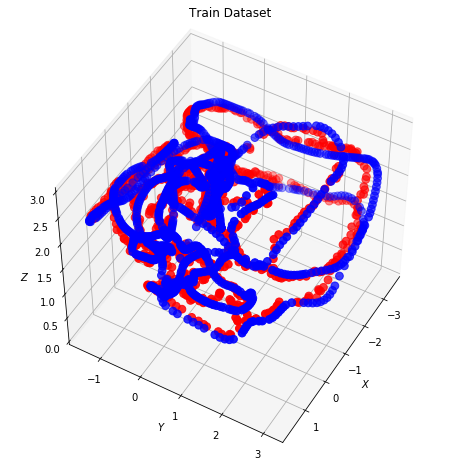

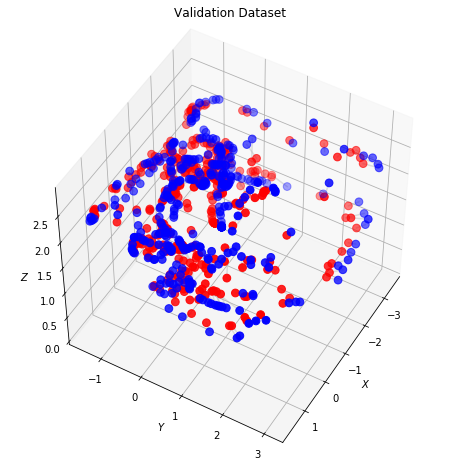

In [71]:
from mpl_toolkits.mplot3d import Axes3D

def calc_poses_params(poses, pose_format='full-mat'):
    """Calculates min, max, mean and std of translations of the poses"""

    p = poses[0]
    allp = extract_translation(p, pose_format)

    for p in poses[1:]:
        allp = np.vstack((allp, extract_translation(p, pose_format)))

    p_min = np.min(allp, axis=0)
    p_max = np.max(allp, axis=0)
    p_mean = np.mean(allp, axis=0)
    p_std = np.std(allp, axis=0)

    return p_min, p_max, p_mean, p_std

def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def extract_translation(p, pose_format='full-mat'):
    if pose_format == 'full-mat':
        return p[0:3, 3]
    elif pose_format == 'quat':
        return p[:3]
    else:
        warnings.warn("pose_format should be either 'full-mat' or 'quat'")
        return p


def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()
    
def draw_poses(ax, poses, c='b', s=20, proj=False, proj_z=0, pose_format='quat'):
    """Draws the list of poses.
    Args:
        ax (Axes3D): 3D axes
        poses (list): Poses list
        c: matplotlib color
        s: matplotlib size
        proj (bool): True if draw projection of a path on z-axis
        proj_z (float): Coord for z-projection
    """
    coords = np.zeros((len(poses), 3))
    for i, p in enumerate(poses):
        # coords[i] = p[:3, 3]
        # coords[i] = p
        coords[i] = extract_translation(p, pose_format=pose_format)

    # Draw projection
    if proj:
        if len(poses) > 1:
            ax.plot(coords[:, 0], coords[:, 1], proj_z, c='g')
        elif len(poses) == 1:
            ax.scatter(coords[:, 0], coords[:, 1], proj_z, c=c)

    # Draw path
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=c, s=s)


def draw_poses_list(ax, poses_list):
    """Draw list of lists of poses."""
    for poses in poses_list:
        draw_poses(ax, poses)


    
# print(pred_poses_train)
# print(gt_poses_train)

# Draw predicted vs ground truth poses
draw_pred_gt_poses(pred_poses_train, gt_poses_train)
plt.title('Train Dataset')
plt.show()


draw_pred_gt_poses(pred_poses_val, gt_poses_val)
plt.title('Validation Dataset')
plt.show()

In [72]:
def save_checkpoint(model, optimizer, criterion, experiment_name='test', epoch=None,
                    time_str=None):
    if not time_str:
        time_str = datetime.now().strftime('%Y%m%d_%H%M%S')
    fname = '{}_{}'.format(time_str, experiment_name)
    if epoch is not None:
        fname += '_e{:03d}'.format(epoch)
    fname += '.pth.tar'

    checkpoints_dir = '_checkpoints'
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    fname_path = os.path.join(checkpoints_dir, fname)

    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict()
    }
    
    if criterion.learn_beta:
        checkpoint_dict.update({'criterion_state_dict': criterion.state_dict()})

    torch.save(checkpoint_dict, fname_path)

    return fname_path



In [73]:
experiment_name = 'IMU_Camera_NoShuffle_5000e_sq=1'

In [74]:
#  Save checkpoint
save_checkpoint(model, optimizer, criterion, 'nb_{}'.format(experiment_name), n_epochs)

'_checkpoints/20190517_170742_nb_IMU_Camera_NoShuffle_5000e_sq=1_e10000.pth.tar'

In [75]:
training_losses=[]
for i in range(len(train_loss)):
    training_losses.append(train_loss[i].val.cpu().clone().numpy())

validation_losses=[]
for i in range(len(test_loss)):   
    validation_losses.append(test_loss[i].val.cpu().clone().numpy())






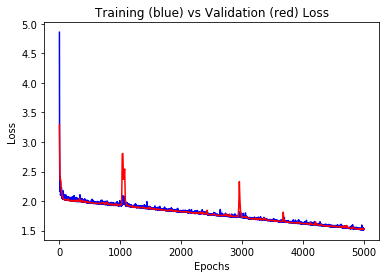

In [52]:
import matplotlib.pyplot as plt

plt.title('Training (blue) vs Validation (red) Loss')
plt.plot(training_losses, '-b', label='trainin loss')
x = np.linspace(0, n_epochs, len(validation_losses), endpoint=True)
plt.plot(x, validation_losses, '-r', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# iter(train_loader).next()

image, label = iter(train_loader).next()

In [ ]:
image

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
# torch.save({
#             'epoch': n_epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss})

torch.save(model,'/home/francesca/Desktop/francesca/model.txt')


In [ ]:


        
# # def train(epoch, model, dataloader, optimizer, criterion):
# def train(train_loader, model, criterion, optimizer, epoch, max_epoch):
#     # switch model to training
#     model.train()
# #     losses = AverageMeter()
#     gt_poses = np.empty((0, 7))
#     pred_poses = np.empty((0, 7))
#     for idx, (batch_images, batch_poses) in enumerate(train_loader):
#         batch_images = batch_images.to(device)
#         batch_poses = batch_poses.to(device)
#         batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
#         out = model(batch_images)
#         loss = criterion(out, batch_poses)
#         # Training step
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
# #         losses.update( batch_images.size(0))
# #         print(len(batch_images))
#         # move data to cpu & numpy
#         bp = batch_poses.detach().cpu().numpy()
# #         print('bp',bp)
# #         print('lnbp',len(bp))
#         outp = out.detach().cpu().numpy()
#         gt_poses = np.vstack((gt_poses, bp))
#         pred_poses = np.vstack((pred_poses, outp))
        
# #         print('outp',outp)
# #         print('bposes',len(batch_poses))
#         # Translation error
# #     for p, t in zip(pred_poses[:, :3], gt_poses[:, :3]):
# #         print('p', p,'t', t)
# #         print('norm',np.linalg.norm(p - t))
# #         print(len(p), len(t))
# #         t_loss.append(np.linalg.norm(p - t)) 

#     # Translation error
#     t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    
#     # Rotation error
#     q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#     print('t_loss :', t_loss)
#     print(t_loss.shape)
#     print('q_loss :', q_loss)
#     print(q_loss.shape)
        

In [ ]:
# def validate(val_loader, model, criterion, epoch):
# #     losses = AverageMeter()
# # set model to evaluation
#     model.eval()

#     for idx, (batch_images, batch_poses) in enumerate(val_loader):
#         batch_images = batch_images.to(device)
#         batch_poses = batch_poses.to(device)
#         batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)


#     # compute model output
#         out = model(batch_poses)
#         loss = criterion(out, batch_poses)
#         print(loss)

In [ ]:
filenames = os.listdir("/home/francesca/Desktop/francesca/data/mav0/cam1/data/")
filenames.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(230)
random.shuffle(filenames) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_1 = int(0.8 * len(filenames))
split_2 = int(0.9 * len(filenames))
train_filenames = filenames[:]
# val_filenames = filenames[split_1:split_2]
# test_filenames = filenames[split_2:]

filenames = {'train': train_filenames}
#              'val': val_filenames,
#              'test': test_filenames}
len(filenames)

In [ ]:
from os import path

from shutil import copytree

train_fol = filenames['train']
# val_fol = filenames['val']
# test_fol = filenames['test']

# source = '/home/francesca/Desktop/francesca/data/mav0/cam0/data'
# dest_folder = '/home/francesca/Desktop/francesca/data/mav0/cam0/data/train'
# for el in test_fol:
#     shutil.copy(path.join(source, el),dest_folder)

# source = '/home/francesca/Desktop/francesca/data/mav0/cam0/data'
# dest_folder = '/home/francesca/Desktop/francesca/val'
# for el in val_fol:
#     shutil.copy(path.join(source, el),dest_folder)

source = '/home/francesca/Desktop/francesca/data/mav0/cam0/data'
dest_folder = '/home/francesca/Desktop/francesca/datafold/data/train'
for el in train_fol:
    shutil.copy(path.join(source, el),dest_folder)

   

In [ ]:
image_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv')
img_name = image_data.iloc[:, 1]

In [ ]:
data_info=pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv')
imagename_arr =np.asarray(data_info.iloc[:, 1])
label_arr = np.asarray(data_info.iloc[:, 2:])
# Image.open(imagename_arr[1])

In [ ]:
fp = "/home/francesca/Desktop/francesca/data/mav0/cam0/data/"
Image.open(fp + imagename_arr[330])
label_arr[1]

In [ ]:
import os

path, dirs, files = next(os.walk("/home/francesca/Desktop/francesca/data/mav0/cam1/data"))
file_count = len(files)
file_count

In [ ]:
from torchvision import datasets, transforms, models
data_dir = '/home/francesca/Desktop/francesca/data/mav0/cam0/'
def load_split_train_test(datadir, valid_size = .2):
    
    
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
#     train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform)
#     test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform)
    train_data = datasets.ImageFolder(data_dir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(len(trainloader.dataset))

In [ ]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some images
dataiter = iter(trainloader)
images = dataiter.next()

In [ ]:
images_dataset = CustomDatasetFromImages('/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv' )
dataset_loader = torch.utils.data.DataLoader(dataset=images_dataset,
                                                    batch_size=10,
                                                    shuffle=True)

dataiter =iter(dataset_loader)
# images = dataiter.next()

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # show images
# plt.figure(figsize=(16,8))
# imshow(torchvision.utils.make_grid(images))


In [ ]:
transform = transforms.Compose(
[transforms.ToTensor(),
 transforms.Scale((32,32)),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder(root="/home/francesca/Desktop/francesca",transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=False, num_workers=2)


In [ ]:
trainset